<a href="https://colab.research.google.com/github/neethu-vm/Deep-learning-neural-networks/blob/main/Text_Classification_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

print(tf.__version__)

2.5.0


In [ ]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .80

In [ ]:
_URL = 'https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv'

PATH = tf.keras.utils.get_file('/bbc-text.csv', origin=_URL, extract=False)



5062656/5057493 [==============================] - 0s 0us/step


In [ ]:
PATH

'/bbc-text.csv'

In [ ]:
import pandas as pd
data = pd.read_csv(PATH)

In [ ]:
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
data.shape

(2225, 2)

In [ ]:
data.category.unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [ ]:
articles = []
labels = []

with open(PATH, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


In [ ]:
labels[0:5]

['tech', 'business', 'sport', 'sport', 'entertainment']

In [ ]:
articles[0:5]

['tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes. us leading trend  programmes content delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us tivo uk sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take europe lack high-definition programming. people forward wind adverts  also forget abiding network channel schedules  putting together a-la-carte entertainment. us networks cable satellite companie

In [ ]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

1780
1780
1780
445
445


In [ ]:
?Tokenizer

Tokenizer does all the heavy lifting for us. In our articles that it was tokenizing, it will take 5,000 most common words. oov_token is to put a special value in when an unseen word is encountered. This means we want <OOV> to be used for words that are not in the word_index

Lets us define an Out Of Vocab token - this will replace any unknown words with a token of our choosing. This is better than just throwing away unknown words since it tells our model there was information here.

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'also': 6,
 'mr': 3,
 'new': 8,
 'one': 10,
 'people': 7,
 'said': 2,
 'us': 9,
 'would': 4,
 'year': 5}

After tokenization, the next step is to turn those tokens into lists of sequence. The following is the 11th article in the training data that has been turned into sequences.

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[2432, 1, 225, 4995, 22, 641, 587, 225, 4995, 1, 1, 1663, 1, 1, 2432, 22, 564, 1, 1, 140, 278, 1, 140, 278, 796, 823, 662, 2308, 1, 1144, 1694, 1, 1721, 4996, 1, 1, 1, 1, 1, 4738, 1, 1, 122, 4514, 1, 2, 2874, 1506, 352, 4739, 1, 52, 341, 1, 352, 2173, 3962, 41, 22, 3796, 1, 1, 1, 1, 542, 1, 1, 1, 835, 631, 2367, 347, 4740, 1, 365, 22, 1, 787, 2368, 1, 4302, 138, 10, 1, 3666, 682, 3531, 1, 22, 1, 414, 823, 662, 1, 90, 13, 633, 1, 225, 4995, 1, 600, 1, 1694, 1021, 1, 4997, 808, 1864, 117, 1, 1, 1, 2975, 22, 1, 99, 278, 1, 1608, 4998, 542, 492, 1, 1444, 4741, 778, 1320, 1, 1861, 10, 33, 641, 319, 1, 62, 478, 564, 301, 1507, 22, 479, 1, 1, 1666, 1, 797, 1, 3067, 1, 1365, 6, 1, 2432, 564, 22, 2972, 4735, 1, 1, 1, 1, 1, 850, 39, 1825, 675, 297, 26, 979, 1, 882, 22, 361, 22, 13, 301, 1507, 1343, 374, 20, 63, 883, 1096, 4303, 247]


In [ ]:
print(train_articles[10])

berlin cheers anti-nazi film german movie anti-nazi resistance heroine drawn loud applause berlin film festival.  sophie scholl - final days portrays final days member white rose movement. scholl  21  arrested beheaded brother  hans  1943 distributing leaflets condemning  abhorrent tyranny  adolf hitler. director marc rothemund said:  feeling responsibility keep legacy scholls going.   must somehow keep ideas alive   added.  film drew transcripts gestapo interrogations scholl trial preserved archive communist east germany secret police. discovery inspiration behind film rothemund  worked closely surviving relatives  including one scholl sisters  ensure historical accuracy film. scholl members white rose resistance group first started distributing anti-nazi leaflets summer 1942. arrested dropped leaflets munich university calling  day reckoning  adolf hitler regime. film focuses six days scholl arrest intense trial saw scholl initially deny charges ended defiant appearance. one three ge

In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print("train_sequences[0]",len(train_sequences[0]))
print("train_padded[0]",len(train_padded[0]))

print("train_sequences[1]",len(train_sequences[1]))
print("train_padded[1]",len(train_padded[1]))

print("train_sequences[10]",len(train_sequences[10]))
print("train_padded[10]",len(train_padded[10]))

train_sequences[0] 425
train_padded[0] 200
train_sequences[1] 192
train_padded[1] 200
train_sequences[10] 186
train_padded[10] 200


In [ ]:
print(train_padded[10])

[2432    1  225 4995   22  641  587  225 4995    1    1 1663    1    1
 2432   22  564    1    1  140  278    1  140  278  796  823  662 2308
    1 1144 1694    1 1721 4996    1    1    1    1    1 4738    1    1
  122 4514    1    2 2874 1506  352 4739    1   52  341    1  352 2173
 3962   41   22 3796    1    1    1    1  542    1    1    1  835  631
 2367  347 4740    1  365   22    1  787 2368    1 4302  138   10    1
 3666  682 3531    1   22    1  414  823  662    1   90   13  633    1
  225 4995    1  600    1 1694 1021    1 4997  808 1864  117    1    1
    1 2975   22    1   99  278    1 1608 4998  542  492    1 1444 4741
  778 1320    1 1861   10   33  641  319    1   62  478  564  301 1507
   22  479    1    1 1666    1  797    1 3067    1 1365    6    1 2432
  564   22 2972 4735    1    1    1    1    1  850   39 1825  675  297
   26  979    1  882   22  361   22   13  301 1507 1343  374   20   63
  883 1096 4303  247    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 200)


Now we are going to look at the labels. Because our labels are text, so we will tokenize them, when training, labels are expected to be numpy arrays. So we will turn list of labels into numpy arrays like so

In [ ]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

berlin <OOV> anti nazi film german movie anti nazi <OOV> <OOV> drawn <OOV> <OOV> berlin film festival <OOV> <OOV> final days <OOV> final days member white rose movement <OOV> 21 arrested <OOV> brother hans <OOV> <OOV> <OOV> <OOV> <OOV> tyranny <OOV> <OOV> director marc <OOV> said feeling responsibility keep legacy <OOV> going must <OOV> keep ideas alive added film drew <OOV> <OOV> <OOV> <OOV> trial <OOV> <OOV> <OOV> east germany secret police discovery <OOV> behind film <OOV> worked closely <OOV> relatives including one <OOV> sisters ensure historical <OOV> film <OOV> members white rose <OOV> group first started <OOV> anti nazi <OOV> summer <OOV> arrested dropped <OOV> munich university calling day <OOV> <OOV> <OOV> regime film <OOV> six days <OOV> arrest intense trial saw <OOV> initially deny charges ended <OOV> appearance one three german films <OOV> top prize festival south african film version <OOV> <OOV> opera <OOV> shot <OOV> town <OOV> language also <OOV> berlin festival film en

Lets Create our RNN Model

In [ ]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 394,694
Trainable params: 394,694
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(set(labels))

{'entertainment', 'tech', 'business', 'politics', 'sport'}


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
num_epochs = 50
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/50
56/56 - 10s - loss: 1.5163 - accuracy: 0.3792 - val_loss: 1.1003 - val_accuracy: 0.5640
Epoch 2/50
56/56 - 1s - loss: 0.7752 - accuracy: 0.6893 - val_loss: 0.6476 - val_accuracy: 0.7461
Epoch 3/50
56/56 - 1s - loss: 0.4189 - accuracy: 0.8483 - val_loss: 0.4206 - val_accuracy: 0.8539
Epoch 4/50
56/56 - 1s - loss: 0.2948 - accuracy: 0.9230 - val_loss: 0.3555 - val_accuracy: 0.8787
Epoch 5/50
56/56 - 1s - loss: 0.0720 - accuracy: 0.9865 - val_loss: 0.2779 - val_accuracy: 0.9079
Epoch 6/50
56/56 - 1s - loss: 0.0184 - accuracy: 0.9983 - val_loss: 0.2922 - val_accuracy: 0.9124
Epoch 7/50
56/56 - 1s - loss: 0.0060 - accuracy: 0.9994 - val_loss: 0.3223 - val_accuracy: 0.9191
Epoch 8/50
56/56 - 1s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.2917 - val_accuracy: 0.9393
Epoch 9/50
56/56 - 1s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.3033 - val_accuracy: 0.9371
Epoch 10/50
56/56 - 1s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3056 - val_accuracy: 0.9371
Epoch 11/50
56/56 

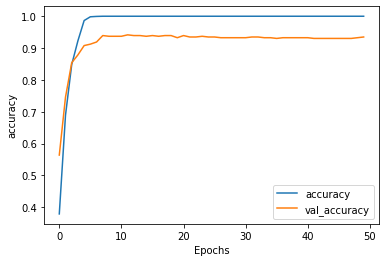

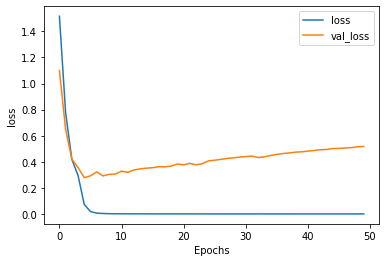

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
yhat = model.predict(validation_padded)

In [ ]:
yhat

array([[4.2827633e-10, 1.3110468e-09, 1.1233536e-05, 1.3680808e-10,
        4.7546986e-05, 9.9994123e-01],
       [2.2967635e-07, 4.3855031e-04, 3.5267943e-04, 3.9617389e-05,
        9.9908447e-01, 8.4464882e-05],
       [4.0352974e-10, 1.2987164e-07, 2.6894033e-06, 9.9998927e-01,
        7.8214880e-06, 8.0387389e-13],
       ...,
       [2.9562092e-10, 5.6417904e-10, 1.7172630e-05, 9.9320226e-11,
        2.0063613e-05, 9.9996281e-01],
       [3.6069108e-07, 1.6974895e-05, 2.5756709e-02, 3.4629747e-02,
        9.3958968e-01, 6.5167219e-06],
       [1.7297420e-08, 9.9999511e-01, 1.5189176e-08, 4.5206795e-07,
        4.4268686e-06, 3.8632610e-08]], dtype=float32)

In [ ]:
ypred = model.predict_classes(validation_padded)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
ypred

array([5, 4, 3, 1, 1, 4, 2, 5, 3, 5, 3, 3, 5, 5, 1, 5, 5, 2, 1, 3, 4, 2,
       1, 5, 4, 3, 3, 1, 1, 3, 2, 2, 2, 2, 5, 2, 3, 3, 4, 4, 5, 3, 5, 2,
       3, 1, 1, 5, 4, 2, 4, 1, 2, 2, 3, 1, 1, 3, 2, 5, 5, 3, 2, 3, 3, 2,
       4, 3, 3, 3, 3, 3, 5, 5, 4, 3, 1, 2, 1, 4, 5, 1, 1, 5, 4, 5, 4, 1,
       4, 1, 1, 5, 5, 2, 5, 5, 3, 2, 1, 4, 4, 2, 2, 1, 5, 5, 1, 3, 5, 1,
       1, 2, 3, 4, 4, 2, 2, 4, 3, 5, 1, 1, 3, 5, 4, 1, 5, 2, 3, 1, 3, 4,
       5, 1, 3, 2, 5, 3, 5, 3, 1, 3, 2, 2, 3, 2, 4, 1, 2, 5, 2, 1, 1, 5,
       4, 3, 4, 3, 3, 1, 1, 1, 2, 4, 5, 3, 1, 2, 1, 2, 4, 2, 2, 2, 2, 1,
       1, 1, 2, 2, 5, 2, 2, 2, 1, 1, 1, 4, 2, 1, 1, 1, 2, 5, 4, 4, 4, 3,
       2, 2, 4, 2, 4, 1, 1, 3, 3, 3, 1, 1, 3, 3, 4, 2, 1, 1, 1, 1, 2, 1,
       2, 2, 2, 2, 1, 3, 1, 4, 4, 1, 4, 2, 5, 2, 1, 2, 4, 4, 3, 5, 2, 5,
       2, 4, 3, 5, 3, 5, 5, 4, 2, 4, 4, 2, 2, 1, 5, 2, 3, 5, 2, 4, 1, 4,
       3, 1, 3, 2, 3, 3, 2, 2, 2, 4, 3, 2, 3, 2, 5, 3, 1, 3, 3, 1, 5, 4,
       4, 2, 4, 1, 2, 2, 5, 1, 4, 4, 4, 1, 5, 1, 3,

In [ ]:
validation_label_seq=validation_label_seq.flatten()

In [ ]:
validation_label_seq

array([5, 4, 3, 1, 1, 4, 2, 4, 5, 5, 3, 3, 2, 5, 1, 5, 5, 2, 1, 3, 4, 2,
       1, 5, 4, 3, 3, 1, 1, 2, 2, 2, 2, 2, 5, 2, 3, 3, 4, 4, 5, 3, 5, 2,
       3, 1, 1, 2, 4, 2, 4, 1, 2, 2, 3, 1, 1, 3, 3, 5, 5, 3, 2, 3, 3, 2,
       4, 3, 3, 3, 3, 3, 5, 5, 4, 3, 1, 3, 1, 4, 1, 1, 1, 5, 4, 5, 4, 1,
       4, 1, 1, 5, 5, 2, 5, 5, 3, 2, 1, 4, 4, 3, 2, 1, 2, 5, 1, 3, 5, 1,
       1, 2, 3, 4, 4, 2, 2, 1, 3, 5, 1, 1, 3, 5, 4, 1, 5, 2, 3, 1, 3, 4,
       5, 1, 3, 2, 5, 3, 5, 3, 1, 3, 2, 2, 3, 2, 4, 1, 2, 5, 2, 1, 1, 5,
       4, 3, 4, 3, 3, 1, 1, 1, 2, 4, 5, 2, 1, 2, 1, 2, 4, 2, 2, 2, 2, 1,
       1, 1, 2, 2, 5, 2, 2, 2, 1, 1, 1, 4, 2, 1, 1, 1, 2, 5, 4, 4, 4, 3,
       2, 2, 4, 2, 4, 1, 1, 3, 3, 3, 1, 1, 3, 3, 4, 2, 1, 1, 1, 1, 2, 1,
       2, 2, 2, 2, 1, 3, 1, 4, 4, 1, 4, 2, 5, 2, 1, 2, 4, 4, 3, 5, 2, 5,
       2, 4, 3, 5, 3, 5, 5, 4, 2, 4, 4, 2, 3, 1, 5, 2, 3, 5, 2, 4, 1, 4,
       3, 1, 3, 2, 3, 3, 2, 2, 2, 4, 3, 2, 3, 2, 5, 3, 1, 3, 3, 1, 5, 4,
       4, 2, 4, 1, 2, 2, 3, 1, 4, 4, 4, 1, 5, 1, 3,

In [ ]:
ypred.shape

(445,)

In [ ]:
validation_label_seq.shape

(445,)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(validation_label_seq, ypred)

array([[96,  0,  1,  2,  2],
       [ 0, 99,  3,  1,  3],
       [ 0,  5, 78,  2,  1],
       [ 1,  2,  0, 81,  2],
       [ 0,  2,  1,  1, 62]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(validation_label_seq, ypred))

              precision    recall  f1-score   support

           1       0.99      0.97      0.98       101
           2       0.88      0.95      0.91       106
           3       0.93      0.94      0.94        86
           4       0.98      0.93      0.95        86
           5       0.98      0.92      0.95        66

    accuracy                           0.95       445
   macro avg       0.95      0.94      0.95       445
weighted avg       0.95      0.95      0.95       445



In [ ]:
#END